<a href="https://colab.research.google.com/github/juanserrano90/codelatam/blob/main/Training/Figures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!git clone https://github.com/juanserrano90/codelatam.git

Cloning into 'codelatam'...
remote: Enumerating objects: 75816, done.
remote: Counting objects: 100% (3999/3999), done.
remote: Compressing objects: 100% (3987/3987), done.
remote: Total 75816 (delta 46), reused 3932 (delta 11), pack-reused 71817 (from 2)
Receiving objects: 100% (75816/75816), 696.79 MiB | 17.25 MiB/s, done.
Resolving deltas: 100% (1306/1306), done.
Updating files: 100% (90968/90968), done.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import pickle
import matplotlib as mpl
import math
from tqdm import tqdm
from collections import defaultdict


from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score

In [6]:
root = "/content/drive/MyDrive/" #Doctorado/Codelatam/

In [7]:
working_dir = root + "/Files_codelatam"
data_dir = "/content/codelatam/Data"
num_classes = 3
inv_dict_mapping_classes = {0:'Ia-norm', 1:'Ia-others', 2:'Others'}
phase1_dir = os.path.join(working_dir, "Runs/Phase1")
phase2_dir = os.path.join(working_dir, "Runs/Phase2")
phase3_dir = os.path.join(working_dir, "Runs/Phase3")

pt_model_names = {'ViT32': 'google/vit-base-patch32-224-in21k',
                  'ViT16': 'google/vit-base-patch16-224-in21k',
                  'Swinv2': 'microsoft/swinv2-tiny-patch4-window16-256',
                  'DINOv3': 'facebook/dinov3-vits16-pretrain-lvd1689m'}

small_names = {
    'ViT32': 'vitb-p32',
    'ViT16': 'vitb-p16',
    'Swinv2': 'swinv2t-p4',
    'DINOv3': 'dinov3-vits16',}

splits = ["split1", "split2", "split3"]


In [8]:
def extract_macro_f1(report_path):
    with open(report_path, "r") as f:
        text = f.read()
    # Match line like:
    # macro avg       0.85      0.84      0.84      1200
    match = re.search(r"macro avg\s+[\d\.]+\s+[\d\.]+\s+([\d\.]+)", text)

    if match is None:
        raise ValueError(f"Could not find macro avg F1 in {report_path}")

    return float(match.group(1))

def subtype_to_class_mapping(a):
  subtype_to_class = {0:0, 1:1, 2:1, 3:1, 4:1, 5:1, 6:2, 7:2, 8:2, 9:2, 10:2, 11:2, 12:2, 13:2, 14:2, 15:2, 16:2}
  return subtype_to_class[a]

def id_to_subtype_mapping(a):
  id_to_subtype = {0: 'Ia-norm', 1: 'Ia-91T', 2: 'Ia-91bg', 3: 'Ia-csm', 4: 'Iax', 5: 'Ia-pec', 6: 'Ib-norm', 7: 'Ibn', 8: 'IIb' , 9: 'Ib-pec',
                   10: 'Ic-norm', 11: 'Ic-broad', 12: 'Ic-pec', 13: 'IIP', 14: 'IIL', 15: 'IIn', 16: 'II-pec'}
  return id_to_subtype[a]

def load_split(n):
  with open(f"{data_dir}/Splits/tvt_split{n}.pkl", 'rb') as f:
    splits = pickle.load(f)
  return splits

def get_sn_info(filename):
    try:
        parts = filename.split('_')
        sn_name = parts[0]
        subtype = int(parts[1])
        phase = parts[3]
        return sn_name, subtype, phase
    except:
        return None, None, None

In [9]:
#phase1_dir = "/content/drive/MyDrive/Doctorado/Codelatam/Files_codelatam/Runs/Phase1"

records = []

for run_name in sorted(os.listdir(phase1_dir)):
    run_path = os.path.join(phase1_dir, run_name)
    if not os.path.isdir(run_path):
        continue

    # Find classification report
    report_files = [
        f for f in os.listdir(run_path)
        if f.startswith("clfreport") and f.endswith(".txt")
    ]

    if len(report_files) == 0:
        continue

    report_path = os.path.join(run_path, report_files[0])
    macro_f1 = extract_macro_f1(report_path)

    # Parse backbone + regime
    # Examples: ViT32_F, ViT32_UF, ViT32_UF4
    parts = run_name.split("_")
    backbone = parts[0]

    if parts[1] == "F":
        regime = "Frozen"
        version = "F"
    elif parts[1].startswith("UF"):
        regime = "Unfrozen"
        version = parts[1]  # UF or UF4
    else:
        regime = "Other"
        version = parts[1]

    records.append({
        "run": run_name,
        "backbone": backbone,
        "regime": regime,
        "version": version,
        "macro_f1": macro_f1,
    })

df = pd.DataFrame(records)
df

""


In [10]:


#phase1_dir = root + "/Files_codelatam/Runs/Phase1"

records = []

for run_name in tqdm(sorted(os.listdir(phase1_dir))):
    run_path = os.path.join(phase1_dir, run_name)
    if not os.path.isdir(run_path):
        continue

    split_results = {}

    for split in splits:
        split_path = os.path.join(run_path, split)
        if not os.path.isdir(split_path):
            split_results[split] = np.nan
            continue

        report_files = [
            f for f in os.listdir(split_path)
            if f.startswith("clfreport") and f.endswith(".txt")
        ]

        if len(report_files) == 0:
            split_results[split] = np.nan
            continue

        report_path = os.path.join(split_path, report_files[0])
        split_results[split] = extract_macro_f1(report_path)

    # Parse backbone + regime
    parts = run_name.split("_")
    backbone = parts[0]

    if parts[1] == "F":
        regime = "Frozen"
        version = "F"
    elif parts[1].startswith("UF"):
        regime = "Unfrozen"
        version = parts[1]
    else:
        regime = "Other"
        version = parts[1]

    values = np.array(list(split_results.values()), dtype=float)

    records.append({
        "run": run_name,
        "backbone": backbone,
        "regime": regime,
        "version": version,
        **split_results,
        "mean": np.nanmean(values),
        "std": np.nanstd(values),
    })

df = pd.DataFrame(records)
df

100%|██████████| 12/12 [00:39<00:00,  3.29s/it]


,run,backbone,regime,version,split1,split2,split3,mean,std
0,DINOv3_F,DINOv3,Frozen,F,0.7056,0.7620,0.7357,0.734433,0.023043
1,DINOv3_UF,DINOv3,Unfrozen,UF,0.8487,0.8815,0.8728,0.867667,0.013874
2,DINOv3_UF4,DINOv3,Unfrozen,UF4,0.8071,0.8391,0.7964,0.814200,0.018141
3,Swinv2_F,Swinv2,Frozen,F,0.6861,0.7103,0.6262,0.674200,0.035350
4,Swinv2_UF,Swinv2,Unfrozen,UF,0.8626,0.8963,0.9093,0.889400,0.019680
5,Swinv2_UF4,Swinv2,Unfrozen,UF4,0.8482,0.8951,0.8787,0.874000,0.019433
6,ViT16_F,ViT16,Frozen,F,0.6875,0.7212,0.6849,0.697867,0.016533
7,ViT16_UF,ViT16,Unfrozen,UF,0.8878,0.8807,0.8723,0.880267,0.006335
8,ViT16_UF4,ViT16,Unfrozen,UF4,0.8313,0.8068,0.7715,0.803200,0.024546
9,ViT32_F,ViT32,Frozen,F,0.6512,0.7109,0.6276,0.663233,0.035055


In [11]:
backbone_order = ["ViT16", "ViT32", "DINOv3", "Swinv2"]
version_order = ["F", "UF4", "UF"]
df["version"] = pd.Categorical(df["version"], categories=version_order, ordered=True)
df = df.sort_values(["version", "regime"])
df

,run,backbone,regime,version,split1,split2,split3,mean,std
0,DINOv3_F,DINOv3,Frozen,F,0.7056,0.7620,0.7357,0.734433,0.023043
3,Swinv2_F,Swinv2,Frozen,F,0.6861,0.7103,0.6262,0.674200,0.035350
6,ViT16_F,ViT16,Frozen,F,0.6875,0.7212,0.6849,0.697867,0.016533
9,ViT32_F,ViT32,Frozen,F,0.6512,0.7109,0.6276,0.663233,0.035055
2,DINOv3_UF4,DINOv3,Unfrozen,UF4,0.8071,0.8391,0.7964,0.814200,0.018141
5,Swinv2_UF4,Swinv2,Unfrozen,UF4,0.8482,0.8951,0.8787,0.874000,0.019433
8,ViT16_UF4,ViT16,Unfrozen,UF4,0.8313,0.8068,0.7715,0.803200,0.024546
11,ViT32_UF4,ViT32,Unfrozen,UF4,0.7693,0.8184,0.7438,0.777167,0.030959
1,DINOv3_UF,DINOv3,Unfrozen,UF,0.8487,0.8815,0.8728,0.867667,0.013874
4,Swinv2_UF,Swinv2,Unfrozen,UF,0.8626,0.8963,0.9093,0.889400,0.019680


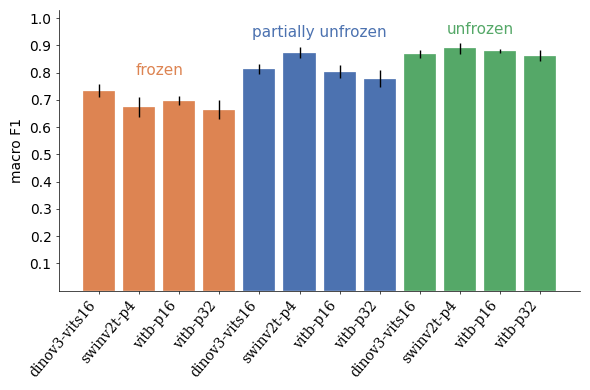

In [12]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=100)

palette = {
    "F": "#DD8452",    # frozen
    "UF4": "#4C72B0",  # partially unfrozen
    "UF": "#55A868",   # unfrozen
}

num_bars = len(df.run)
bar_colors = []
for i in range(num_bars):
    if i < 4:
        bar_colors.append(palette['F'])
    elif i < 8:
        bar_colors.append(palette['UF4'])
    else:
        bar_colors.append(palette['UF'])
names_ = pd.Series([str(small_names[i.split('_')[0]]+'_'+i.split('_')[1]) for i in df.run])
ax.bar(names_, df['mean'],
       yerr=df['std'],
       error_kw={'elinewidth':1},
       color=bar_colors,
       edgecolor='white',
       linewidth=0.2,
       capsize=0,
       zorder=1000)
ax.set_ylabel("macro F1")
ax.set_xticks(
    names_,
    labels=[f.split('_')[0] for f in names_],
    rotation=50,
    ha='right',
)
for label in ax.get_xticklabels():
    label.set_fontweight('regular')
    label.set_fontsize(10)
    label.set_family("serif")

ax.set_ylim(0, 1.03)
ax.set_yticks(np.arange(0.1, 1.1, 0.1))
ax.text(1.5, 0.78, "frozen",
        ha="center", va="bottom",
        fontsize=11, fontweight="normal",
        color=palette["F"])
ax.text(5.5, 0.92, "partially unfrozen",
        ha="center", va="bottom",
        fontsize=11, fontweight="normal",
        color=palette["UF4"])
ax.text(9.5, 0.93, "unfrozen",
        ha="center", va="bottom",
        fontsize=11, fontweight="normal",
        color=palette["UF"])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
ax.tick_params(which='major', width=0.5, length=2)

plt.tight_layout()
# plt.savefig(
#     os.path.join(working_dir, "Plots", "phase1_macro_f1_comparison.png"),
#     dpi=300,
#     bbox_inches="tight"
# )
plt.show()

In [13]:


def build_phase2_dataframe(phase2_dir):
    records = []
    splits = ["split1", "split2", "split3"]

    for backbone in tqdm(sorted(os.listdir(phase2_dir))):
        backbone_path = os.path.join(phase2_dir, backbone)
        if not os.path.isdir(backbone_path):
            continue

        for representation in sorted(os.listdir(backbone_path)):
            rep_path = os.path.join(backbone_path, representation)
            if not os.path.isdir(rep_path):
                continue

            split_scores = {}

            for split in splits:
                split_path = os.path.join(rep_path, split)
                if not os.path.isdir(split_path):
                    print(f"⚠️ Missing {split_path}")
                    split_scores[split] = np.nan
                    continue

                report_files = [
                    f for f in os.listdir(split_path)
                    if f.startswith("clfreport_") and f.endswith(".txt")
                ]

                if len(report_files) == 0:
                    print(f"⚠️ No report found in {split_path}")
                    split_scores[split] = np.nan
                    continue

                if len(report_files) > 1:
                    print(f"⚠️ Multiple reports found in {split_path}, using first one")

                report_path = os.path.join(split_path, report_files[0])
                split_scores[split] = extract_macro_f1(report_path)

            values = np.array(list(split_scores.values()), dtype=float)

            records.append({
                "backbone": backbone,
                "representation": representation,
                "macro_f1_mean": np.nanmean(values),
                "macro_f1_std": np.nanstd(values),
                **split_scores
            })

    return pd.DataFrame(records)

In [14]:
df_phase2 = build_phase2_dataframe(phase2_dir)
df_phase2.sort_values(
    by=["backbone", "macro_f1_mean"],
    ascending=[True, False],
    inplace=True
)
df_phase2.reset_index(drop=True, inplace=True)
df_phase2.head()

100%|██████████| 4/4 [03:23<00:00, 50.93s/it]


,backbone,representation,macro_f1_mean,macro_f1_std,split1,split2,split3
0,DINOv3,v2.0,0.866900,0.013691,0.8497,0.8832,0.8678
1,DINOv3,v2.0_50x50,0.796933,0.015307,0.7757,0.8112,0.8039
2,DINOv3,v2.0_224x112,0.790800,0.033128,0.8010,0.8253,0.7461
3,DINOv3,v2.0_20x20_n,0.787733,0.016831,0.7781,0.8114,0.7737
4,DINOv3,v2.0_224x56_n,0.787500,0.035552,0.8203,0.8041,0.7381


In [15]:
df2 = df_phase2.copy()
rep_order = (
    df2.groupby("representation")["macro_f1_mean"]
      .mean()
      .sort_values(ascending=True)
      .index
)
df2["representation"] = pd.Categorical(
    df2["representation"],
    categories=rep_order,
    ordered=True
)

df2.sort_values(["representation", "backbone"], inplace=True)
df2.reset_index(drop=True, inplace=True)

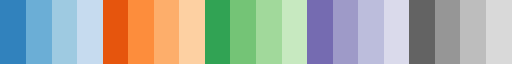

In [16]:

# tab20c colormap
cmap = mpl.colormaps["tab20c"]
cmap

In [17]:
df2.head()

,backbone,representation,macro_f1_mean,macro_f1_std,split1,split2,split3
0,DINOv3,v2.0_224x224_n,0.757667,0.027463,0.7791,0.7750,0.7189
1,Swinv2,v2.0_224x224_n,0.715433,0.024206,0.6894,0.7477,0.7092
2,ViT16,v2.0_224x224_n,0.709900,0.008832,0.7009,0.7219,0.7069
3,ViT32,v2.0_224x224_n,0.688133,0.028876,0.6583,0.7272,0.6789
4,DINOv3,v2.0_224x112_n,0.773433,0.024189,0.8042,0.7710,0.7451


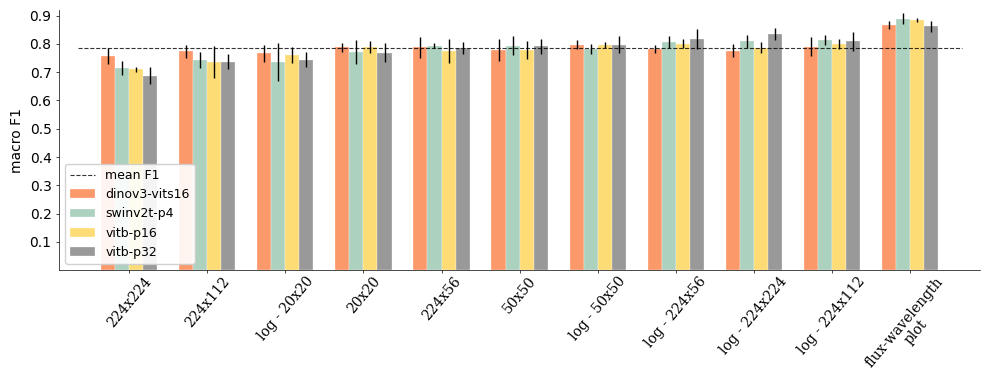

In [18]:
representations = df2["representation"].astype('category').cat.categories
representations = [i[5:] for i in representations]
representations[-1] = "Spectrum"

backbones = df2["backbone"].unique()
mean_f1 = df2["macro_f1_mean"].mean()
n_rep = len(representations)
n_back = len(backbones)

bar_width = 0.18
x = np.arange(n_rep)

palette = {
    "ViT32":  "#999999", #"#3c9fd0", #cmap(16),
    "ViT16":  "#fddc75", #cmap(9),
    "DINOv3": "#fc996b", #cmap(5),
    "Swinv2": "#add1bf", #cmap(1),
}

palette_strong = {
    "ViT32":  "#4d4d4d",   # strong neutral gray (clearly visible)
    "ViT16":  "#e3b100",   # saturated gold
    "DINOv3": "#e4572e",   # vivid orange-red
    "Swinv2": "#2a9d8f",   # deep teal
}

fig, ax = plt.subplots(figsize=(10, 4), dpi=100)

for i, backbone in enumerate(backbones):
    subset = df2[df2["backbone"] == backbone]
    ax.bar(
        x + i * bar_width,
        subset["macro_f1_mean"],
        width=bar_width,
        yerr=subset['macro_f1_std'],
        error_kw={'elinewidth':1},
        edgecolor='white',
        linewidth=0.2,
        capsize=0,
        label=small_names[backbone],
        color=palette.get(backbone),
        zorder=0,
    )
ax.axhline(
    mean_f1,
    xmin=0.02, xmax=0.98,
    color="black",
    linestyle="--",
    linewidth=0.8,
    alpha=0.8,
    zorder=500,
    label=f"mean F1"
)
ax.set_ylabel("macro F1")

ax.set_xticks(
    x + bar_width * (n_back - 1) / 2,
    labels=[rep.replace("_n","") if "_n" in rep else "log - " + rep for rep in representations[:-1]] + ["flux-wavelength\nplot"], rotation=50, ha="center")

ax.tick_params(axis='x', labelsize=10, labelfontfamily='serif', pad=1)
ax.legend(
    loc='lower left',
    title="",
    frameon=True,
    framealpha=0.9,
    fontsize=9,
    title_fontsize=10,
)
ax.set_ylim(0, 0.92)
ax.set_yticks(np.arange(0.1, 1.0, 0.1))


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
ax.tick_params(which='major', width=0.5, length=2)
plt.tight_layout()
# plt.savefig(
#     os.path.join(working_dir, "Plots", "phase2_macro_f1_comparison.png"),
#     dpi=300,
#     bbox_inches="tight"
# )
plt.show()

In [19]:
# Phase 3

In [22]:

HP_PATTERN = re.compile(
    r"bs_(\d+)_lr_[^_]+_wd_([\d\.]+)_dp_([\d\.]+)"
)

def build_phase3_dataframes(phase3_dir, dataset_name="v2.0"):
    model_dfs = {}

    for model in tqdm(sorted(os.listdir(phase3_dir))):
        model_path = os.path.join(phase3_dir, model)
        if not os.path.isdir(model_path):
            continue

        dataset_path = os.path.join(model_path, dataset_name)
        if not os.path.isdir(dataset_path):
            continue

        scores = defaultdict(dict)

        for split in ["split1", "split2", "split3"]:
            split_path = os.path.join(dataset_path, split)
            if not os.path.isdir(split_path):
                continue

            # 🔹 Recursive search
            for root, _, files in os.walk(split_path):
                for fname in files:
                    if not (fname.startswith("clfreport") and fname.endswith(".txt")):
                        continue

                    try:
                        bs, wd, dp = parse_hparams_from_fname(fname)
                    except ValueError as e:
                        print(f"[WARN] {e}")
                        continue


                    report_path = os.path.join(root, fname)
                    macro_f1 = extract_macro_f1(report_path)

                    scores[(bs, wd, dp)][split] = macro_f1

        # Build DataFrame
        records = []
        for (bs, wd, dp), split_scores in scores.items():
            f1s = [
                split_scores.get("split1"),
                split_scores.get("split2"),
                split_scores.get("split3"),
            ]

            if any(v is None for v in f1s):
                continue

            records.append({
                "batch_size": bs,
                "weight_decay": wd,
                "dropout": dp,
                "f1_split1": f1s[0],
                "f1_split2": f1s[1],
                "f1_split3": f1s[2],
                "f1_mean": sum(f1s) / 3,
                "f1_std": pd.Series(f1s).std(ddof=1),
            })

        df = pd.DataFrame(records)
        if not df.empty:
            df = df.sort_values("f1_mean", ascending=False).reset_index(drop=True)

        model_dfs[model] = df

    return model_dfs
def parse_hparams_from_fname(fname):
    name = fname.replace(".txt", "")
    parts = name.split("_")

    params = {}
    i = 0

    while i < len(parts) - 1:
        key = parts[i]
        val = parts[i + 1]

        if key in {"bs", "wd", "dp"}:
            if key == "bs":
                params["bs"] = int(val)
            elif key == "wd":
                params["wd"] = float(val)
            elif key == "dp":
                params["dp"] = float(val)
            i += 2
        else:
            i += 1

    if not {"bs", "wd", "dp"} <= params.keys():
        raise ValueError(f"Missing hparams in {fname}")

    return params["bs"], params["wd"], params["dp"]


In [24]:
model_results = build_phase3_dataframes(phase3_dir)

# Example: view ViT16 results
model_results["ViT16"].head()

100%|██████████| 4/4 [00:01<00:00,  3.19it/s]


,batch_size,weight_decay,dropout,f1_split1,f1_split2,f1_split3,f1_mean,f1_std
0,32,0.00010,0.1,0.8876,0.8995,0.9104,0.899167,0.011404
1,32,0.00100,0.3,0.9065,0.8950,0.8901,0.897200,0.008418
2,64,0.00100,0.3,0.9071,0.9020,0.8792,0.896100,0.014856
3,64,0.00010,0.1,0.8909,0.8994,0.8944,0.894900,0.004272
4,64,0.00001,0.3,0.9021,0.8789,0.9020,0.894333,0.013366


In [25]:
def top_k_table(model_results, k=2):
    tables = []

    for model, df in model_results.items():
        if df.empty:
            continue

        topk = df.head(k).copy()
        topk.insert(0, "model", model)

        # Optional: prettier formatting
        topk["f1_mean"] = topk["f1_mean"].map(lambda x: f"{x:.3f}")
        topk["f1_std"]  = topk["f1_std"].map(lambda x: f"{x:.3f}")

        tables.append(topk)

    if not tables:
        return pd.DataFrame()

    return pd.concat(tables, ignore_index=True)


In [26]:
top2_df = top_k_table(model_results, k=10)
top2_df.sort_values("f1_mean", ascending=False)

,model,batch_size,weight_decay,dropout,f1_split1,f1_split2,f1_split3,f1_mean,f1_std
20,ViT16,32,0.00010,0.1,0.8876,0.8995,0.9104,0.899,0.011
21,ViT16,32,0.00100,0.3,0.9065,0.8950,0.8901,0.897,0.008
22,ViT16,64,0.00100,0.3,0.9071,0.9020,0.8792,0.896,0.015
23,ViT16,64,0.00010,0.1,0.8909,0.8994,0.8944,0.895,0.004
10,Swinv2,32,0.00100,0.3,0.8655,0.9076,0.9093,0.894,0.025
25,ViT16,64,0.00001,0.5,0.8990,0.8925,0.8897,0.894,0.005
24,ViT16,64,0.00001,0.3,0.9021,0.8789,0.9020,0.894,0.013
12,Swinv2,32,0.00001,0.3,0.8655,0.9076,0.9093,0.894,0.025
11,Swinv2,32,0.00010,0.3,0.8655,0.9076,0.9093,0.894,0.025
0,DINOv3,32,0.00001,0.5,0.8816,0.9146,0.8855,0.894,0.018


In [27]:
# join them in a single object
rows = [
    top2_df[top2_df['model'] == 'DINOv3'].loc[0],
    top2_df[top2_df['model'] == 'Swinv2'].loc[11],
    top2_df[top2_df['model'] == 'ViT16'].loc[23],
    top2_df[top2_df['model'] == 'ViT32'].loc[30],
]

joined_df = pd.concat(rows, axis=1).T.reset_index(drop=True)
joined_df

,model,batch_size,weight_decay,dropout,f1_split1,f1_split2,f1_split3,f1_mean,f1_std
0,DINOv3,32,0.00001,0.5,0.8816,0.9146,0.8855,0.894,0.018
1,Swinv2,32,0.0001,0.3,0.8655,0.9076,0.9093,0.894,0.025
2,ViT16,64,0.0001,0.1,0.8909,0.8994,0.8944,0.895,0.004
3,ViT32,32,0.0001,0.5,0.8566,0.8948,0.8471,0.866,0.025


In [28]:
# Inference plots

In [29]:
final_models = {
    "ViT16": {"bs": 64, "dropout": 0.1, "wd": 1e-4, "file_name": "model_bs_64_lr_1e-05_wd_0.0001_dp_0.1_pt_10_f_False_h3.pth"},
    "ViT32": {"bs": 32, "dropout": 0.5, "wd": 1e-4, "file_name": "model_bs_32_lr_1e-05_wd_0.0001_dp_0.5_pt_10_f_False_h3.pth"},
    "Swinv2": {"bs": 32, "dropout": 0.3, "wd": 1e-4, "file_name": "model_bs_32_lr_1e-05_wd_0.0001_dp_0.3_pt_10_f_False_h3.pth"},
    "DINOv3": {"bs": 32, "dropout": 0.5, "wd": 1e-5, "file_name": "model_bs_32_lr_1e-05_wd_1e-05_dp_0.5_pt_10_f_False_h3.pth"},
}

In [30]:
# Ensemble
outputs_dicts = {}

for m in final_models.keys():
  with open(f"{working_dir}/Runs/Test/output_dict_"+m+".pkl", 'rb') as f:
    outputs_dicts[m] = pickle.load(f)

with open(f"{working_dir}/Runs/Test/output_dict_ensemble_soft.pkl", 'rb') as f:
  outputs_dicts["Ensemble"] = pickle.load(f)

y_true = np.array(outputs_dicts["ViT16"]["y_true"])

preds = {
    "ViT16": np.array(outputs_dicts["ViT16"]["y_pred"]),
    "Swinv2": np.array(outputs_dicts["Swinv2"]["y_pred"]),
    "DINOv3": np.array(outputs_dicts["DINOv3"]["y_pred"]),
    "ViT32": np.array(outputs_dicts["ViT32"]["y_pred"]),
    "Ensemble": np.array(outputs_dicts["ViT16"]["y_pred"]),
}

probs = {
    "ViT16": np.array(outputs_dicts["ViT16"]["y_pred_prob"]),
    "Swinv2": np.array(outputs_dicts["Swinv2"]["y_pred_prob"]),
    "DINOv3": np.array(outputs_dicts["DINOv3"]["y_pred_prob"]),
    "ViT32": np.array(outputs_dicts["ViT32"]["y_pred_prob"]),
    "Ensemble": np.array(outputs_dicts["ViT16"]["y_pred_prob"]),
}

In [31]:
print(f"--------- \t ROC AUC (ovo weighted) \t ROC AUC (ovr weighted)")
for m in outputs_dicts.keys():
  r = roc_auc_score(outputs_dicts[m]['y_true'], outputs_dicts[m]['y_pred_prob'], multi_class='ovo', average="weighted")
  r2 = roc_auc_score(outputs_dicts[m]['y_true'], outputs_dicts[m]['y_pred_prob'], multi_class='ovr', average="weighted")
  print(f"{m:<10} \t {r:.2f}                       \t {r2:.2f}")

--------- 	 ROC AUC (ovo weighted) 	 ROC AUC (ovr weighted)
ViT16      	 0.95                       	 0.95
ViT32      	 0.94                       	 0.95
Swinv2     	 0.97                       	 0.97
DINOv3     	 0.95                       	 0.95
Ensemble   	 0.97                       	 0.98


In [32]:
def round_up_decimal(n, decimals=0):
    """
    Rounds a number up to a specified number of decimal places.
    """
    if decimals == 0:
        return math.ceil(n)
    factor = 10**decimals
    return math.ceil(n * factor) / factor

precision: 98.35, recall: 73.66, threshold: 0.9931, False, True, False
precision: 98.34, recall: 73.25, threshold: 0.994, False, True, False
precision: 98.33, recall: 72.84, threshold: 0.9944, False, True, False
precision: 98.32, recall: 72.43, threshold: 0.9945, False, True, False
precision: 98.31, recall: 72.02, threshold: 0.9947, False, True, False
precision: 98.87, recall: 72.02, threshold: 0.9949, False, True, False
precision: 98.86, recall: 71.6, threshold: 0.995, False, True, False
precision: 99.43, recall: 71.6, threshold: 0.995, False, True, False
precision: 99.43, recall: 71.19, threshold: 0.996, False, True, False
precision: 99.42, recall: 70.78, threshold: 0.9961, False, True, False
precision: 99.42, recall: 70.37, threshold: 0.9966, False, True, False
precision: 99.42, recall: 69.96, threshold: 0.9966, False, True, False
precision: 99.41, recall: 69.55, threshold: 0.9967, False, True, False
precision: 99.41, recall: 69.14, threshold: 0.9968, False, True, False
precision: 9

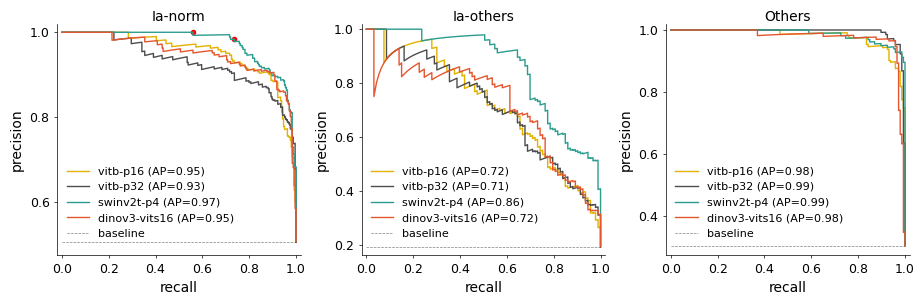

In [83]:
fig, ax = plt.subplots(1,3, figsize=(11,3), dpi=100)
fig.subplots_adjust(wspace=0.25)
palette_strong = {
    "ViT32":  "#4d4d4d",   # strong neutral gray (clearly visible)
    "ViT16":  "#e3b100",   # saturated gold
    "DINOv3": "#e4572e",   # vivid orange-red
    "Swinv2": "#2a9d8f",   # deep teal
}
kwargs={'fontsize':9}
for i in range(3):
  for m in final_models.keys():

    y_true_bin = (outputs_dicts[m]["y_true"] == i).astype(int)
    baseline = y_true_bin.mean()
    precision, recall, thresholds = precision_recall_curve(
        y_true_bin,
        outputs_dicts[m]["y_pred_prob"][:, i]
    )
    if m == "Swinv2":
      if i == 0:
        select = (precision <= 1) * (precision >= 0.98)
        rs, ps, ts = [], [], []
        plotdot = True
        firstcomplete = False
        for j,p in enumerate(precision[select][:-1]):
          rs.append(recall[select][j])
          ts.append(thresholds[select[:-1]][j])
          ps.append(p)
          print(f"precision: {p*100:.4}, recall: {rs[-1]*100:.4}, threshold: {ts[-1]:.4}, {np.round(p,3)==1.00}, {noplot}, {firstcomplete}")
          firstcomplete = np.round(p,3)==1 & plotdot
          if (j==0 or firstcomplete) and  plotdot:
            ax[i].plot(rs[-1], ps[-1], 'r.')
            if firstcomplete and j>0:
              plotdot = False


    ap = average_precision_score(y_true_bin, outputs_dicts[m]["y_pred_prob"][:, i])
    ax[i].plot(
        recall,
        precision,
        label=f"{small_names[m]} (AP={ap:.2f})",
        color=palette_strong[m],
        lw=1)
  ax[i].hlines(
      baseline, 0, 1,
      colors="k", linestyles="dashed", linewidth=0.5,
      alpha=0.5, label='baseline')
  ax[i].set_yticks(np.arange(0, 1.1, 0.2), labels=[str(round(i,2)) for i in np.arange(0, 1.1, 0.2)], **kwargs)
  ax[i].set_ylim(baseline - 0.03, 1.02)
  ax[i].set_xlabel("recall", size=10)
  ax[i].set_ylabel("precision", size=10)
  ax[i].set_xlim(-0.02,1.02)
  ax[i].set_title(f"{inv_dict_mapping_classes[i]}", size=10, pad=0.2)

  ax[i].set_xticks(np.arange(0, 1.1, 0.2), labels=[str(round(i,2)) for i in np.arange(0, 1.1, 0.2)], **kwargs)
  ax[i].legend(fontsize=8, loc=(0.02, 0.05), frameon=False)
for i in range(3):
  ax[i].spines['right'].set_visible(False)
  ax[i].spines['top'].set_visible(False)
  ax[i].spines['left'].set_linewidth(0.5)
  ax[i].spines['bottom'].set_linewidth(0.5)
  ax[i].tick_params(which='major', width=0.5, length=2)

plt.savefig(
    os.path.join(working_dir, "Plots", "precision-recall.png"),
    dpi=300,
    bbox_inches="tight")
plt.show()

Model: ViT16 -------------------
pred_class           0   1   2
true_subtype_name             
IIP                  0   3  18
IIb                  0   1  23
Ia-91T              27  49   2
Ia-91bg              1  12   1
Ia-norm            223  15   5
Ia-pec               1   0   0
Ib-norm              0   1  25
Ic-broad             0   0  14
Ic-norm              0   9  52
pred_class                0         1         2
true_subtype_name                              
IIP                0.000000  0.142857  0.857143
IIb                0.000000  0.041667  0.958333
Ia-91T             0.346154  0.628205  0.025641
Ia-91bg            0.071429  0.857143  0.071429
Ia-norm            0.917695  0.061728  0.020576
Ia-pec             1.000000  0.000000  0.000000
Ib-norm            0.000000  0.038462  0.961538
Ic-broad           0.000000  0.000000  1.000000
Ic-norm            0.000000  0.147541  0.852459
true_subtype_name
Ia-91T     29
Ia-norm    20
Ic-norm     9
IIP         3
Ia-91bg     2
Ia-pec    

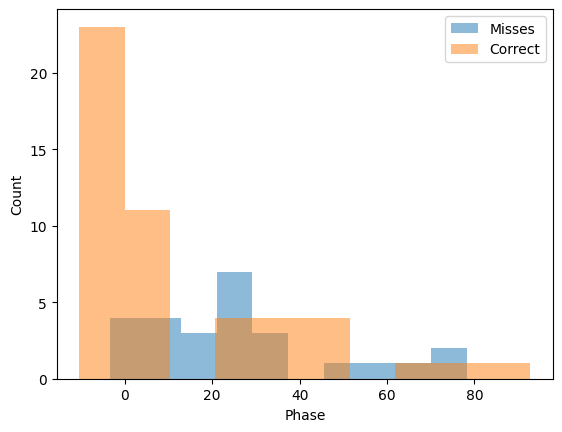

------------------------
Model: ViT32 -------------------
pred_class           0   1   2
true_subtype_name             
IIP                  0   1  20
IIb                  0   0  24
Ia-91T              29  48   1
Ia-91bg              2  10   2
Ia-norm            215  23   5
Ia-pec               1   0   0
Ib-norm              0   0  26
Ic-broad             0   0  14
Ic-norm              1   1  59
pred_class                0         1         2
true_subtype_name                              
IIP                0.000000  0.047619  0.952381
IIb                0.000000  0.000000  1.000000
Ia-91T             0.371795  0.615385  0.012821
Ia-91bg            0.142857  0.714286  0.142857
Ia-norm            0.884774  0.094650  0.020576
Ia-pec             1.000000  0.000000  0.000000
Ib-norm            0.000000  0.000000  1.000000
Ic-broad           0.000000  0.000000  1.000000
Ic-norm            0.016393  0.016393  0.967213
true_subtype_name
Ia-91T     30
Ia-norm    28
Ia-91bg     4
Ic-norm     2

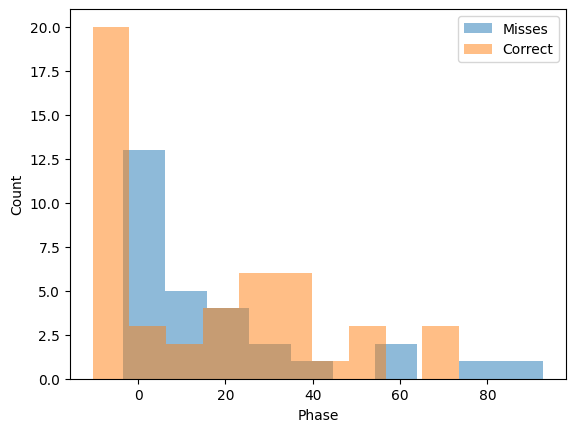

------------------------
Model: Swinv2 -------------------
pred_class           0   1   2
true_subtype_name             
IIP                  0   0  21
IIb                  0   1  23
Ia-91T              24  54   0
Ia-91bg              0  11   3
Ia-norm            226  11   6
Ia-pec               1   0   0
Ib-norm              0   0  26
Ic-broad             0   1  13
Ic-norm              2   2  57
pred_class                0         1         2
true_subtype_name                              
IIP                0.000000  0.000000  1.000000
IIb                0.000000  0.041667  0.958333
Ia-91T             0.307692  0.692308  0.000000
Ia-91bg            0.000000  0.785714  0.214286
Ia-norm            0.930041  0.045267  0.024691
Ia-pec             1.000000  0.000000  0.000000
Ib-norm            0.000000  0.000000  1.000000
Ic-broad           0.000000  0.071429  0.928571
Ic-norm            0.032787  0.032787  0.934426
true_subtype_name
Ia-91T      24
Ia-norm     17
Ic-norm      4
Ia-91bg  

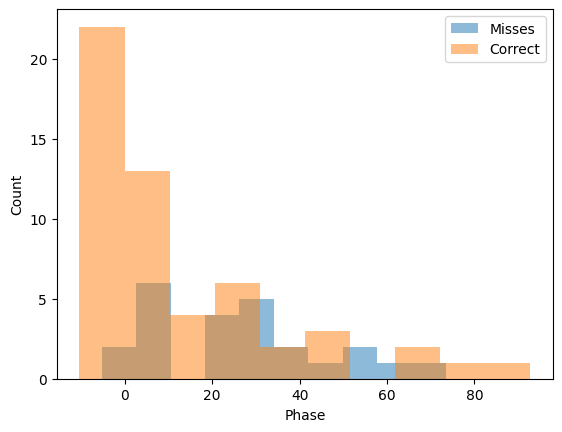

------------------------
Model: DINOv3 -------------------
pred_class           0   1   2
true_subtype_name             
IIP                  0   1  20
IIb                  0   0  24
Ia-91T              25  52   1
Ia-91bg              2  11   1
Ia-norm            223  18   2
Ia-pec               0   1   0
Ib-norm              1   1  24
Ic-broad             1   0  13
Ic-norm              1   9  51
pred_class                0         1         2
true_subtype_name                              
IIP                0.000000  0.047619  0.952381
IIb                0.000000  0.000000  1.000000
Ia-91T             0.320513  0.666667  0.012821
Ia-91bg            0.142857  0.785714  0.071429
Ia-norm            0.917695  0.074074  0.008230
Ia-pec             0.000000  1.000000  0.000000
Ib-norm            0.038462  0.038462  0.923077
Ic-broad           0.071429  0.000000  0.928571
Ic-norm            0.016393  0.147541  0.836066
true_subtype_name
Ia-91T      26
Ia-norm     20
Ic-norm     10
Ia-91bg  

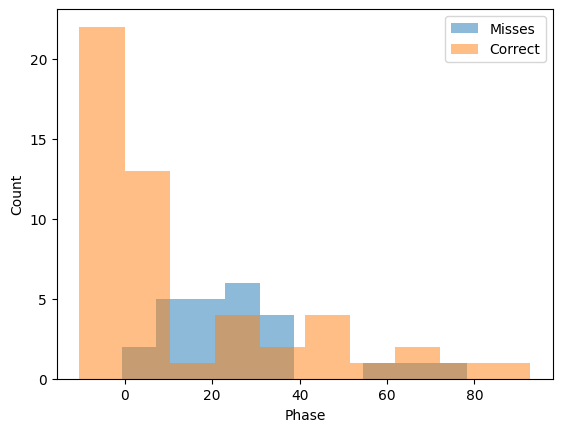

------------------------


In [56]:
# missclassification analysis
for m in final_models.keys():
  print(f'Model: {m} -------------------')
  rows = []
  for i, fname in enumerate(outputs_dicts[m]["id"]):

      _, true_subtype, phase = get_sn_info(fname)
      true_class = subtype_to_class_mapping(true_subtype)

      pred_class = int(outputs_dicts[m]["y_pred"][i])

      rows.append({
          "filename": fname,
          "true_subtype": true_subtype,
          "true_subtype_name": id_to_subtype_mapping(true_subtype),
          "phase": phase,
          "true_class": true_class,
          "pred_class": pred_class,
          "correct": true_class == pred_class
      })

  df = pd.DataFrame(rows)
  subtype_to_class_conf = (
    df.groupby(["true_subtype_name", "pred_class"])
      .size()
      .unstack(fill_value=0))
  print(subtype_to_class_conf)
  subtype_to_class_conf_norm = subtype_to_class_conf.div(
    subtype_to_class_conf.sum(axis=1), axis=0)
  print(subtype_to_class_conf_norm)
  df_miss = df[~df["correct"]]
  print(df_miss["true_subtype_name"].value_counts())
  print((df_miss["true_subtype_name"].value_counts() / df["true_subtype_name"].value_counts()).sort_values(ascending=False))
  print(pd.crosstab(df_miss["true_subtype_name"], df_miss["pred_class"], normalize="index"))
  idx_miss = df_miss.index.to_numpy()
  p_true = outputs_dicts[m]["y_pred_prob"][idx_miss, df_miss["true_class"]]
  p_pred = outputs_dicts[m]["y_pred_prob"][idx_miss, df_miss["pred_class"]]
  print(pd.DataFrame({"p_true_class": p_true,"p_pred_class": p_pred}).describe().iloc[1])

  # Phase analysis for Ia-91T
  df_91T = df[df["true_subtype_name"] == "Ia-91T"]
  df_91T_miss = df_91T[
      (df_91T["pred_class"] == 0) &  # predicted Ia-norm
      (~df_91T["correct"])]
  phase_correct = (df_91T[df_91T["correct"]]["phase"]
      .value_counts(normalize=False)
      .sort_index())
  phase_miss = (
      df_91T_miss["phase"]
      .value_counts(normalize=False)
      .sort_index())
  plt.hist(phase_miss.index.astype(float), alpha=0.5, label='Misses')
  plt.hist(phase_correct.index.astype(float), alpha=0.5, label='Correct')
  plt.legend(loc='best')
  plt.xlabel('Phase')
  plt.ylabel('Count')
  plt.show()
  print(f'------------------------')

In [57]:
# confusion matrices
from sklearn.metrics import confusion_matrix
def fpr(y_true, y_pred, labels=None):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    N = cm.sum()

    fpr = {}
    for c in range(cm.shape[0]):
        FP = cm[:, c].sum() - cm[c, c]
        FN = cm[c, :].sum() - cm[c, c]
        TN = N - (FP + FN + cm[c, c])
        fpr[c] = FP / (FP + TN)

    return fpr

cm = {}
cm_normalized = {}

for m in final_models.keys():
  cm[m] = confusion_matrix(outputs_dicts[m]['y_true'], outputs_dicts[m]['y_pred'])
  cm_normalized[m] = cm[m].astype(float) / cm[m].sum(axis=1)[:, np.newaxis]
  print(f"FPR for model {m}-----")
  fprs = fpr(outputs_dicts[m]["y_true"], outputs_dicts[m]["y_pred"])
  print([float(round(i,2)) for i in fprs.values()])

FPR for model ViT16-----
[0.12, 0.07, 0.02]
FPR for model ViT32-----
[0.14, 0.06, 0.02]
FPR for model Swinv2-----
[0.11, 0.04, 0.03]
FPR for model DINOv3-----
[0.13, 0.07, 0.01]


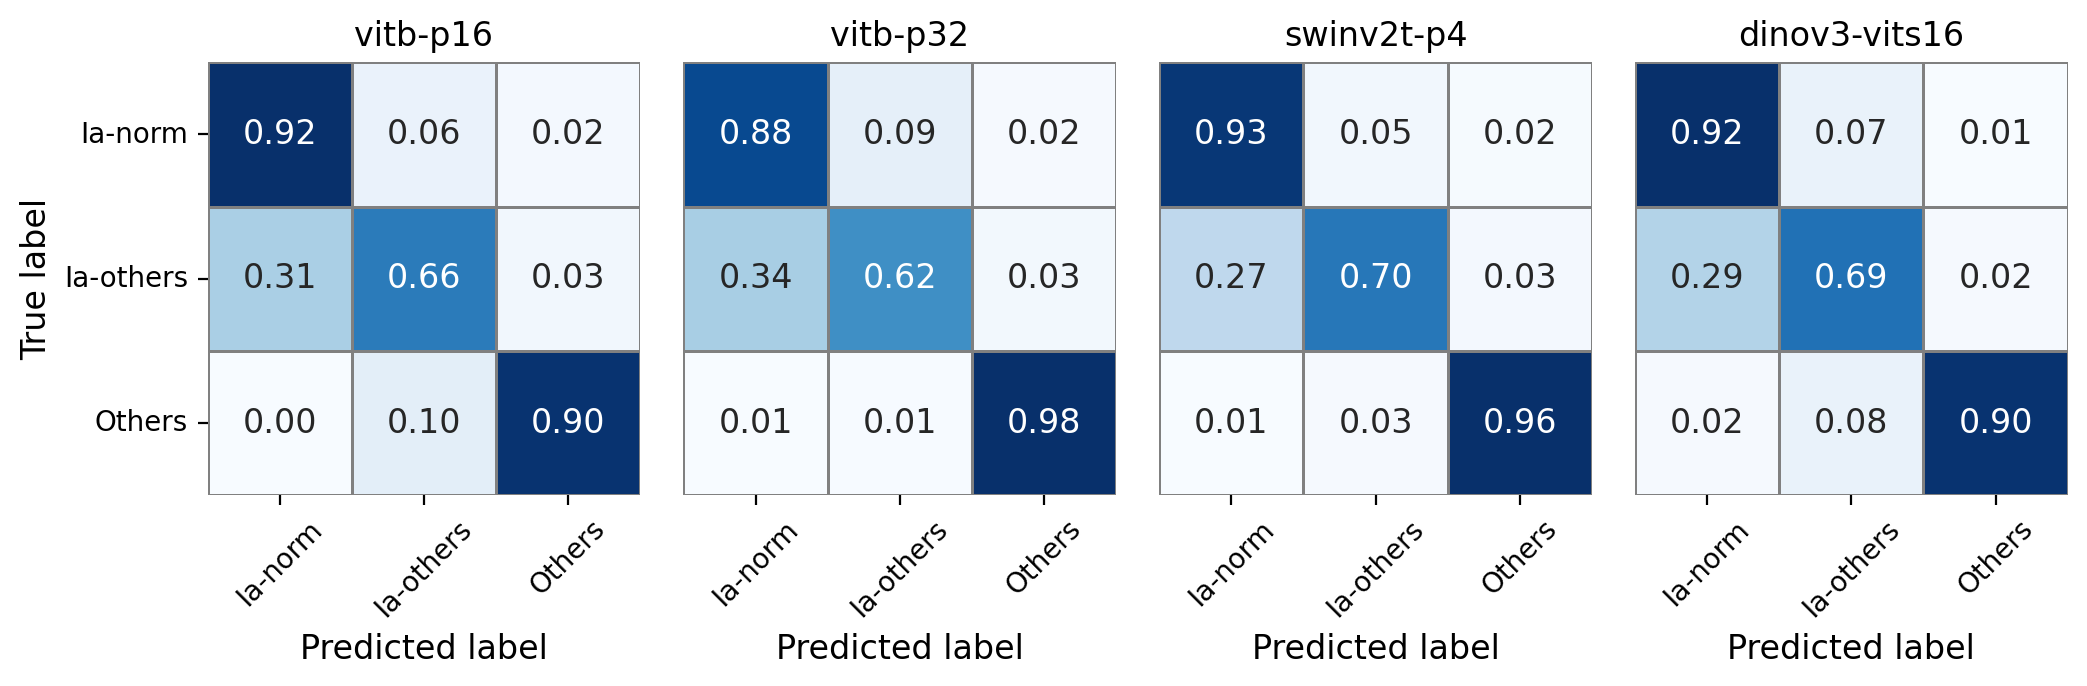

In [58]:
class_names = ['Ia-norm', 'Ia-others', 'Others']
titles = []
fig, ax = plt.subplots(1,4, figsize=(12, 3), dpi=200)
fig.subplots_adjust(wspace=0.1)
for i,m in enumerate(final_models.keys()):
  sns.heatmap(
      cm_normalized[m],
      annot=True,
      fmt=".2f",
      cmap="Blues",
      cbar=False,
      cbar_kws={'label': 'Fraction of samples'},
      xticklabels=class_names,
      yticklabels=class_names,
      linewidths=0.5,
      linecolor='gray',
      square=True,
      annot_kws={"size": 12},
      ax=ax[i]
  )
  if i == 0:
    ax[i].set_ylabel("True label", fontsize=12)
  else:
    ax[i].set_ylabel("")
    ax[i].set_yticks([])
  ax[i].set_xlabel("Predicted label", fontsize=12)
  ax[i].tick_params(axis='x', labelrotation=45, labelsize=10)
  ax[i].tick_params(axis='y', labelrotation=0, labelsize=10)
  ax[i].set_title(f"{small_names[m]}", fontsize=12)
n_classes = len(class_names)

plt.savefig(
    os.path.join(working_dir, "Plots", "cm_matrices.png"),
    dpi=300,
    bbox_inches="tight"
)
plt.show()